In [1]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import ipdb as pdb
import time

for k in range(5):
    
    print('---------' + str(k) + '------------')
    
    MAX_EPISODE = 100
    MAX_EPISODE_LEN = 10000

    NUM_T = 1
    NUM_R = 4
    SIGMA2 = 1e-9

    t_factor = 0.5
    noise_sigma = 0.12

    config = {'state_dim':3, 'action_dim':2};
    train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                    'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                    'random_seed':int(time.clock()*1000%1000), 'noise_sigma':noise_sigma, 'sigma2':SIGMA2}
    
#     rate = 2.0
    res_path = 't_nB_OGD/'
    model_path = 'model_M_r40_nB_dqn/my_train_model_'+str(k)+'-2000'
    meta_path = model_path+'.meta'
    init_path = ''
    user_config = [{'id':'1', 'model':'AR', 'num_r':NUM_R, 'rate':1.0, 'dis':50, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000, 'action_level':5},
                   {'id':'2', 'model':'AR', 'num_r':NUM_R, 'rate':2.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000, 'action_level':5},
                   {'id':'3', 'model':'AR', 'num_r':NUM_R, 'rate':3.0, 'dis':150, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000, 'action_level':5}]

    if not os.path.exists(res_path):
        os.mkdir(res_path) 
        
    print(user_config)

    # 1. include all user in the system according to the user_config
    user_list = [];
    for info in user_config:
        info.update(config)
        user_list.append(MecTermGD_M(info, train_config, 'offload'))
        print('Initialization OK!----> user ' + info['id'])

    # 2. create the simulation env
    env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)

    # #Create a saver object which will save all the variables
    # saver = tf.train.Saver() 

    res_r = []
    res_p = []
    res_b = []
    res_o = []
    res_d = []
    # 3. start to explore for each episode
    for i in range(MAX_EPISODE):

        cur_init_ds_ep = env.reset(isTrain=False)

        cur_r_ep = np.zeros(len(user_list))
        cur_p_ep = np.zeros(len(user_list))
        cur_op_ep = np.zeros(len(user_list))
        cur_ts_ep = np.zeros(len(user_list))
        cur_ps_ep = np.zeros(len(user_list))
        cur_rs_ep = np.zeros(len(user_list))
        cur_ds_ep = np.zeros(len(user_list))
        cur_ch_ep = np.zeros(len(user_list))
        cur_of_ep = np.zeros(len(user_list))

        for j in range(MAX_EPISODE_LEN):
            
            # first try to transmit from current state
            [cur_r, done, cur_p, cur_op, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()

            cur_r_ep += cur_r
            cur_p_ep += cur_p
            cur_op_ep += cur_op
            cur_ts_ep += cur_ts
            cur_ps_ep += cur_ps
            cur_rs_ep += cur_rs
            cur_ds_ep += cur_ds
            cur_ch_ep += cur_ch
            cur_of_ep += cur_of


            if done:
                res_r.append(cur_r_ep/MAX_EPISODE_LEN)
                res_p.append(cur_p_ep/MAX_EPISODE_LEN)
                res_b.append(cur_ds_ep/MAX_EPISODE_LEN)
                res_o.append(cur_of_ep/MAX_EPISODE_LEN)
                res_d.append(cur_ds)
                print('%d:r:%s,p:%s,op:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s,rbuf:%s' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_op_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep, cur_ds))

    name = res_path+'test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
    np.savez(name, res_r, res_p, res_b, res_o, res_d)
    


---------0------------
[{'penalty': 1000, 'num_r': 4, 'rate': 1.0, 'action_bound': 2, 'data_buf_size': 100, 'action_level': 5, 'model': 'AR', 'id': '1', 't_factor': 0.5, 'dis': 50}, {'penalty': 1000, 'num_r': 4, 'rate': 2.0, 'action_bound': 2, 'data_buf_size': 100, 'action_level': 5, 'model': 'AR', 'id': '2', 't_factor': 0.5, 'dis': 100}, {'penalty': 1000, 'num_r': 4, 'rate': 3.0, 'action_bound': 2, 'data_buf_size': 100, 'action_level': 5, 'model': 'AR', 'id': '3', 't_factor': 0.5, 'dis': 150}]
Initialization OK!----> user 1
Initialization OK!----> user 2
Initialization OK!----> user 3
0:r:[ -1.64883454  -9.43086439 -20.03670805],p:[0.21876015 1.6633574  3.41905512],op:[0. 0. 0.],tr:[1.13312533 1.51201569 0.99043205],pr:[0.01765231 0.63731701 2.05320384],rev:[1.005  2.0037 3.0096],dbuf:[1.11006761 2.22815476 5.8828649 ],ch:[31.2766022   4.07008917  1.1721731 ],ibuf:[0, 0, 0],rbuf:[2.         3.         9.83593475]
1:r:[ -1.64223902  -9.50304758 -19.86532553],p:[0.21779163 1.67719261 3.

23:r:[ -1.67473142  -9.57484635 -19.94466582],p:[0.22459258 1.6932853  3.38865922],op:[0. 0. 0.],tr:[1.12039142 1.47137823 1.007487  ],pr:[0.02114173 0.66262278 2.02605757],rev:[0.9955 1.9921 2.9953],dbuf:[1.10353708 2.2168397  6.00273944],ch:[31.81832876  3.83288624  1.2079202 ],ibuf:[0, 0, 0],rbuf:[2.21756505 1.00275871 5.        ]
24:r:[ -1.56080494  -9.47159479 -19.62711309],p:[0.20396432 1.67168769 3.37143472],op:[0. 0. 0.],tr:[1.10240071 1.49437778 1.0117618 ],pr:[0.01681265 0.64612697 2.01200455],rev:[0.9791 1.9993 2.9843],dbuf:[1.08196669 2.22631269 5.53987897],ch:[32.46009681  3.99287972  1.20721593],ibuf:[0, 0, 0],rbuf:[1.50074907 2.35416722 9.5730243 ]
25:r:[ -1.69226995  -9.43008554 -20.04001793],p:[0.2275919  1.66441412 3.42183095],op:[0. 0. 0.],tr:[1.13032542 1.4840587  0.95002434],pr:[0.01923256 0.64145724 2.05721192],rev:[1.0013 1.9815 2.9727],dbuf:[1.10862089 2.21602984 5.86172631],ch:[31.42671739  4.06058154  1.13507589],ibuf:[0, 0, 0],rbuf:[ 4.          3.03437689 17

48:r:[ -1.62351032  -9.39950798 -19.87863224],p:[0.21459465 1.66012874 3.37882307],op:[0. 0. 0.],tr:[1.12260736 1.47974973 1.00515727],pr:[0.01562161 0.64485664 2.0150822 ],rev:[0.9955 1.9818 2.9822],dbuf:[1.10107415 2.19772852 5.96903383],ch:[31.46241831  4.04285316  1.20383143],ibuf:[0, 0, 0],rbuf:[2.        2.        4.0624698]
49:r:[ -1.67676689  -9.61780816 -20.08666602],p:[0.22343004 1.69851178 3.40613255],op:[0. 0. 0.],tr:[1.13637962 1.50960872 1.03405197],pr:[0.02125091 0.65617134 2.04208151],rev:[1.012  2.0206 3.0406],dbuf:[1.11923336 2.25049856 6.11200652],ch:[32.10535008  3.98792276  1.24213194],ibuf:[0, 0, 0],rbuf:[ 0.          1.29758486 16.9459458 ]
50:r:[ -1.66327385  -9.3252391  -20.13346988],p:[0.22172855 1.64507838 3.40977647],op:[0. 0. 0.],tr:[1.12919674 1.49219423 0.98777864],pr:[0.01822918 0.63113202 2.04162857],rev:[1.0026 1.9759 2.9936],dbuf:[1.10926215 2.19969437 6.16917506],ch:[32.492789    4.02837797  1.1757693 ],ibuf:[0, 0, 0],rbuf:[ 0.05595524  2.         10

73:r:[ -1.58400058  -9.54970367 -19.65267027],p:[0.20663283 1.68631373 3.34740414],op:[0. 0. 0.],tr:[1.12208653 1.49762097 1.02424933],pr:[0.01530813 0.65569266 1.98830466],rev:[0.996  2.011  2.9736],dbuf:[1.1016729  2.23627007 5.83129919],ch:[32.05069144  4.022315    1.23013064],ibuf:[0, 0, 0],rbuf:[2.         3.         5.19368537]
74:r:[ -1.6303813   -9.46011377 -20.04337213],p:[0.21669266 1.66920433 3.40871331],op:[0. 0. 0.],tr:[1.11080124 1.50187977 1.00105836],pr:[0.02138105 0.64830107 2.04482563],rev:[0.9897 2.0043 3.0116],dbuf:[1.09383601 2.22818427 5.99961118],ch:[31.8846509  4.069918   1.1852033],ibuf:[0, 0, 0],rbuf:[1.05946049 0.         4.13596189]
75:r:[ -1.61695203  -9.37508144 -19.91980937],p:[0.2139182  1.65357093 3.37833783],op:[0. 0. 0.],tr:[1.11553604 1.48994159 1.00045734],pr:[0.01759742 0.63933375 2.01750587],rev:[0.991  1.9886 2.9803],dbuf:[1.09472201 2.21445356 6.05624044],ch:[32.40507961  4.0882946   1.18963359],ibuf:[0, 0, 0],rbuf:[1.         4.         4.99145

98:r:[ -1.55208718  -9.53277142 -20.46250375],p:[0.20143935 1.68241771 3.43210045],op:[0. 0. 0.],tr:[1.11125367 1.49796027 0.98254171],pr:[0.01320329 0.65669095 2.05985734],rev:[0.9895 2.0156 3.008 ],dbuf:[1.08978081 2.24136571 6.60400299],ch:[32.74738851  3.93250919  1.15355849],ibuf:[0, 0, 0],rbuf:[2.         1.         0.68814899]
99:r:[ -1.66744238  -9.42266344 -20.57202947],p:[0.22237572 1.66267915 3.44405817],op:[0. 0. 0.],tr:[1.13226309 1.50454069 0.96954338],pr:[0.01901596 0.63193756 2.07058225],rev:[1.0044 1.9907 3.0052],dbuf:[1.11112754 2.21853537 6.70347725],ch:[31.64002752  4.07945243  1.16165342],ibuf:[0, 0, 0],rbuf:[1.         3.18130263 2.62852736]
---------1------------
[{'penalty': 1000, 'num_r': 4, 'rate': 1.0, 'action_bound': 2, 'data_buf_size': 100, 'action_level': 5, 'model': 'AR', 'id': '1', 't_factor': 0.5, 'dis': 50}, {'penalty': 1000, 'num_r': 4, 'rate': 2.0, 'action_bound': 2, 'data_buf_size': 100, 'action_level': 5, 'model': 'AR', 'id': '2', 't_factor': 0.5, 

21:r:[ -1.63131601  -9.54058856 -19.83816053],p:[0.21585313 1.68613318 3.3807934 ],op:[0. 0. 0.],tr:[1.12720203 1.48102734 1.00789642],pr:[0.01571845 0.66071452 2.02078008],rev:[0.9967 1.9983 2.9905],dbuf:[1.10410074 2.21984527 5.86838703],ch:[31.05182056  3.89204231  1.17679273],ibuf:[0, 0, 0],rbuf:[1.0424064  4.19947765 9.65847587]
22:r:[ -1.62928902  -9.46231785 -19.71849529],p:[0.2152572  1.66995936 3.3600223 ],op:[0. 0. 0.],tr:[1.12384706 1.49434308 1.01033821],pr:[0.01835494 0.6471302  2.00074936],rev:[1.0008 1.9986 2.9714],dbuf:[1.10600604 2.22504212 5.83676753],ch:[31.3641594   4.04348675  1.19148104],ibuf:[0, 0, 0],rbuf:[1.50994412 2.44436967 6.93911193]
23:r:[ -1.59256487  -9.48768287 -19.58921882],p:[0.20773231 1.67544438 3.36443032],op:[0. 0. 0.],tr:[1.13317667 1.48639436 1.00616265],pr:[0.01332036 0.65549485 2.00623171],rev:[1.0042 1.9977 2.9739],dbuf:[1.10780668 2.22092197 5.53413445],ch:[32.2277434   4.02363623  1.204468  ],ibuf:[0, 0, 0],rbuf:[0.         2.09155357 5.  

46:r:[ -1.66633954  -9.56916422 -20.01180681],p:[0.22126477 1.68997999 3.39496925],op:[0. 0. 0.],tr:[1.13626425 1.50318634 1.01553581],pr:[0.02075445 0.65866906 2.02634947],rev:[1.0134 2.0176 3.0059],dbuf:[1.12003139 2.23852857 6.07392115],ch:[31.06997546  3.88656962  1.20161079],ibuf:[0, 0, 0],rbuf:[0.         0.         4.01492035]
47:r:[ -1.6112796   -9.47504233 -20.16375584],p:[0.21208231 1.67241012 3.42365507],op:[0. 0. 0.],tr:[1.12411804 1.48797587 0.98159671],pr:[0.01625819 0.64746624 2.05440184],rev:[0.9982 1.995  3.0001],dbuf:[1.10173615 2.22598342 6.09096099],ch:[32.57513028  3.95148789  1.15334795],ibuf:[0, 0, 0],rbuf:[3. 0. 3.]
48:r:[ -1.63417179  -9.51583729 -20.30455923],p:[0.21629722 1.67878253 3.44438987],op:[0. 0. 0.],tr:[1.12034437 1.49451934 0.97906913],pr:[0.01876337 0.65749017 2.07244547],rev:[0.9982 2.0086 3.0172],dbuf:[1.10537142 2.24384928 6.16521976],ch:[32.32732739  3.97290667  1.15979571],ibuf:[0, 0, 0],rbuf:[1.09210083 0.08111704 4.14011406]
49:r:[ -1.640007

71:r:[ -1.60873897  -9.69962103 -20.17166447],p:[0.21333554 1.71521662 3.42210188],op:[0. 0. 0.],tr:[1.10244572 1.47092615 0.97901504],pr:[0.01604223 0.67847019 2.05115948],rev:[0.9766 2.004  2.997 ],dbuf:[1.08412259 2.24707584 6.12231014],ch:[32.22047686  3.88653292  1.14312703],ibuf:[0, 0, 0],rbuf:[ 0.02299768  3.         13.20345819]
72:r:[ -1.66152158  -9.27684495 -19.57257155],p:[0.22170891 1.63621381 3.36654554],op:[0. 0. 0.],tr:[1.1259996  1.49368424 1.00698955],pr:[0.0185708  0.62195368 2.00462154],rev:[0.9993 1.9734 2.9722],dbuf:[1.10595411 2.19155182 5.47968772],ch:[31.46223435  4.10560362  1.19304009],ibuf:[0, 0, 0],rbuf:[1.         2.64149951 1.85702155]
73:r:[ -1.67867431  -9.48087232 -19.79899801],p:[0.22450145 1.67065835 3.3871977 ],op:[0. 0. 0.],tr:[1.1335071  1.51373302 0.99994208],pr:[0.01926986 0.64909082 2.02711381],rev:[1.0057 2.0185 2.9889],dbuf:[1.1123341  2.25516116 5.726019  ],ch:[31.78636117  4.06456885  1.15829205],ibuf:[0, 0, 0],rbuf:[2.08949166 1.17134722 2

96:r:[ -1.66100508  -9.51754246 -19.76510406],p:[0.22145177 1.68019118 3.39262546],op:[0. 0. 0.],tr:[1.12806146 1.50585058 0.99944743],pr:[0.01802749 0.65054828 2.03293595],rev:[0.9996 2.0127 2.9946],dbuf:[1.10749244 2.23317313 5.60395347],ch:[30.68955188  3.94146853  1.18996497],ibuf:[0, 0, 0],rbuf:[0.14836947 2.20555857 6.82298058]
97:r:[ -1.64159469  -9.34348096 -20.38777394],p:[0.21818104 1.64672269 3.42974   ],op:[0. 0. 0.],tr:[1.12396733 1.50290114 0.98973688],pr:[0.01833155 0.63114068 2.06139111],rev:[0.9979 1.991  3.017 ],dbuf:[1.10137895 2.21973507 6.47814791],ch:[31.64674279  4.17417582  1.18072879],ibuf:[0, 0, 0],rbuf:[ 0.06304823  0.         16.62808338]
98:r:[ -1.64952179  -9.36537352 -20.47033753],p:[0.21925168 1.65086839 3.45394914],op:[0. 0. 0.],tr:[1.12907455 1.49375967 0.99244168],pr:[0.01605872 0.64084336 2.0815365 ],rev:[0.999  1.9926 3.0389],dbuf:[1.10652678 2.22206315 6.40118365],ch:[31.78886695  4.13819027  1.1674758 ],ibuf:[0, 0, 0],rbuf:[2.13841899 3.05145239 8

19:r:[ -1.59388366  -9.56433508 -20.23231685],p:[0.21036853 1.68876085 3.41610177],op:[0. 0. 0.],tr:[1.10458737 1.47866477 1.00409239],pr:[0.01622301 0.6686     2.04787735],rev:[0.9788 2.0076 3.0156],dbuf:[1.08408197 2.24106168 6.30361596],ch:[32.2626285   3.99221513  1.21124933],ibuf:[0, 0, 0],rbuf:[0.         2.39402035 3.51238918]
20:r:[ -1.64283989  -9.47343241 -19.87139757],p:[0.21775429 1.67214681 3.38676081],op:[0. 0. 0.],tr:[1.12515326 1.48692774 1.01259874],pr:[0.02184907 0.65192373 2.02008489],rev:[1.0028 1.999  2.9969],dbuf:[1.10813691 2.22539672 5.87518705],ch:[32.47910776  4.03956446  1.19752149],ibuf:[0, 0, 0],rbuf:[1.27428852 4.33661496 2.        ]
21:r:[ -1.54542856  -9.47660017 -19.94837618],p:[0.1989582  1.67252415 3.39684581],op:[0. 0. 0.],tr:[1.12392681 1.49348211 1.00989089],pr:[0.01497712 0.64744814 2.03049516],rev:[0.9991 2.0011 3.0062],dbuf:[1.10127514 2.22795886 5.92829427],ch:[33.24184827  4.01241847  1.17769197],ibuf:[0, 0, 0],rbuf:[1.         3.15939143 8.41

44:r:[ -1.6368258   -9.61355815 -20.61174853],p:[0.21710687 1.69847767 3.45230955],op:[0. 0. 0.],tr:[1.12119028 1.49165179 0.9665109 ],pr:[0.01964904 0.6678092  2.07689468],rev:[0.9948 2.0158 3.0106],dbuf:[1.10258288 2.24233955 6.70040157],ch:[31.64303827  3.88839383  1.12534576],ibuf:[0, 0, 0],rbuf:[0.02734656 1.09696478 4.94031322]
45:r:[ -1.69788669  -9.53404602 -19.96773653],p:[0.22763072 1.68221069 3.41156232],op:[0. 0. 0.],tr:[1.14166084 1.4833407  0.98318941],pr:[0.01957437 0.65643879 2.04432672],rev:[1.0097 2.0007 2.993 ],dbuf:[1.11946618 2.24598511 5.81984984],ch:[31.18866062  3.97511434  1.16517205],ibuf:[0, 0, 0],rbuf:[ 1.          2.         11.12003407]
46:r:[ -1.64039703  -9.64884194 -20.24681217],p:[0.21837931 1.70386181 3.44361467],op:[0. 0. 0.],tr:[1.11974528 1.49956906 0.97576973],pr:[0.01867792 0.65880127 2.07332227],rev:[0.9915 2.015  3.0167],dbuf:[1.09700098 2.25906578 6.05747768],ch:[31.55970585  3.93753629  1.158586  ],ibuf:[0, 0, 0],rbuf:[2.15489402 2.88319303 1

69:r:[ -1.69294731  -9.45050642 -20.46428309],p:[0.22509164 1.66606831 3.4290003 ],op:[0. 0. 0.],tr:[1.15283919 1.51244091 0.98894529],pr:[0.02183286 0.64207032 2.05951978],rev:[1.0281 2.0108 3.0142],dbuf:[1.13497822 2.24032973 6.63856314],ch:[32.13486631  4.01223348  1.15576171],ibuf:[0, 0, 0],rbuf:[1.         1.02892862 6.28912385]
70:r:[ -1.63527204  -9.49310965 -19.99274434],p:[0.21886165 1.67609279 3.40645496],op:[0. 0. 0.],tr:[1.10230785 1.48931113 1.00240569],pr:[0.01835231 0.64832355 2.0433545 ],rev:[0.9781 1.9944 3.0078],dbuf:[1.08192759 2.22529134 5.92093905],ch:[31.03654657  3.92542931  1.17384029],ibuf:[0, 0, 0],rbuf:[1.10558529 3.59956177 5.80018263]
71:r:[ -1.58415624  -9.55040131 -19.72584612],p:[0.20765337 1.68660634 3.38053955],op:[0. 0. 0.],tr:[1.10955596 1.49428324 0.9924439 ],pr:[0.01637925 0.65628682 2.02369704],rev:[0.9859 2.0063 2.9781],dbuf:[1.09177876 2.23473921 5.64629672],ch:[32.57985164  4.02043635  1.16798467],ibuf:[0, 0, 0],rbuf:[1.         1.         1.45

94:r:[ -1.67661383  -9.68785221 -20.02306423],p:[0.22221207 1.71340824 3.41424917],op:[0. 0. 0.],tr:[1.1510127  1.47796924 0.98188268],pr:[0.01939365 0.67694657 2.04393485],rev:[1.0225 2.0122 2.9897],dbuf:[1.13110697 2.24162204 5.90363674],ch:[31.52917537  4.01415072  1.17518349],ibuf:[0, 0, 0],rbuf:[2.         1.38659719 0.00913925]
95:r:[ -1.69090132  -9.51611268 -20.02302679],p:[0.22679954 1.68068149 3.40948635],op:[0. 0. 0.],tr:[1.12971355 1.49223638 0.976079  ],pr:[0.02128075 0.648838   2.04305153],rev:[1.0043 1.9949 2.9844],dbuf:[1.11380722 2.22541044 5.9511901 ],ch:[31.10885103  4.03283393  1.17373598],ibuf:[0, 0, 0],rbuf:[ 3.          3.         13.39318188]
96:r:[ -1.67292456  -9.54928974 -20.46002537],p:[0.22451366 1.68687032 3.43738323],op:[0. 0. 0.],tr:[1.12217536 1.47700267 0.99222278],pr:[0.01865687 0.66310168 2.0658632 ],rev:[0.9942 1.9938 3.0232],dbuf:[1.10071256 2.22987624 6.5462184 ],ch:[31.62719076  4.08270925  1.20556843],ibuf:[0, 0, 0],rbuf:[0.         3.         3

17:r:[ -1.60284897  -9.42951147 -20.40405359],p:[0.2086683  1.66300456 3.43019453],op:[0. 0. 0.],tr:[1.14313294 1.50834247 1.01903331],pr:[0.01561356 0.64385721 2.05516585],rev:[1.0146 2.0112 3.0418],dbuf:[1.1190149  2.22897736 6.50616186],ch:[32.16775584  4.01575859  1.21212927],ibuf:[0, 0, 0],rbuf:[ 0.48201075  1.20247043 20.66684836]
18:r:[ -1.64529095  -9.55416803 -20.27507758],p:[0.2181261  1.68753008 3.42419658],op:[0. 0. 0.],tr:[1.12826369 1.49029157 0.98404851],pr:[0.0194058  0.65697805 2.05543905],rev:[1.0029 2.0027 3.0028],dbuf:[1.10932094 2.23303521 6.3081894 ],ch:[31.85028987  3.98416519  1.16131815],ibuf:[0, 0, 0],rbuf:[0.         6.18760134 6.05044004]
19:r:[ -1.67725315  -9.65802762 -20.25157087],p:[0.22396697 1.70770405 3.40412854],op:[0. 0. 0.],tr:[1.13610178 1.47715285 1.00832109],pr:[0.01900305 0.67316527 2.04018433],rev:[1.0094 2.0059 3.0109],dbuf:[1.11483659 2.2390147  6.4618563 ],ch:[31.8741198   3.93355684  1.21829279],ibuf:[0, 0, 0],rbuf:[0.28410898 3.14142952 3

42:r:[ -1.61741604  -9.472367   -19.83146277],p:[0.2121119  1.67248772 3.37408762],op:[0. 0. 0.],tr:[1.13482718 1.48942252 1.00453868],pr:[0.01712761 0.65426454 2.01094747],rev:[1.0087 2.0008 2.9769],dbuf:[1.11371306 2.21985679 5.92204937],ch:[32.11234389  3.91391037  1.17320365],ibuf:[0, 0, 0],rbuf:[0.         1.03976792 8.80548383]
43:r:[ -1.5970737   -9.44578533 -20.25830336],p:[0.20847263 1.66827694 3.43381801],op:[0. 0. 0.],tr:[1.13254884 1.49439169 0.99168508],pr:[0.015816   0.63491324 2.06272863],rev:[1.0031 1.9852 3.0184],dbuf:[1.1094211  2.20880132 6.17842659],ch:[33.53927216  3.96871869  1.17253481],ibuf:[0, 0, 0],rbuf:[1.         1.10161817 2.        ]
44:r:[ -1.5976776   -9.38664059 -20.15704396],p:[0.20929885 1.65602422 3.41889413],op:[0. 0. 0.],tr:[1.12243222 1.49420361 1.00261731],pr:[0.01591341 0.63929502 2.04960108],rev:[1.     1.9921 3.0165],dbuf:[1.1023667  2.21303894 6.12514661],ch:[32.33980747  3.97641991  1.19372213],ibuf:[0, 0, 0],rbuf:[2. 4. 4.]
45:r:[ -1.715631

67:r:[ -1.62089051  -9.51865501 -19.67384119],p:[0.21398414 1.67957741 3.374375  ],op:[0. 0. 0.],tr:[1.12488785 1.50376046 0.99038388],pr:[0.01567293 0.65681123 2.01389616],rev:[0.9979 2.015  2.9675],dbuf:[1.10193967 2.24153594 5.6039324 ],ch:[32.09266586  4.12810526  1.19335163],ibuf:[0, 0, 0],rbuf:[2.         1.         3.18387826]
68:r:[ -1.6321317   -9.4198387  -19.79326214],p:[0.21720942 1.66409142 3.38704094],op:[0. 0. 0.],tr:[1.10924407 1.47682701 1.01924519],pr:[0.0177472  0.64130579 2.02150989],rev:[0.9874 1.9761 3.0036],dbuf:[1.09216925 2.19876319 5.71611484],ch:[31.66629445  3.89781087  1.2149142 ],ibuf:[0, 0, 0],rbuf:[0.11212553 1.32146107 3.        ]
69:r:[ -1.6245712   -9.49524579 -19.97366516],p:[0.21648542 1.6789258  3.40244886],op:[0. 0. 0.],tr:[1.10490838 1.46805914 0.98706169],pr:[0.01708905 0.6499426  2.03562399],rev:[0.9766 1.9727 2.9867],dbuf:[1.08428816 2.20123355 5.9228417 ],ch:[32.33816907  4.02481367  1.20280386],ibuf:[0, 0, 0],rbuf:[ 2.30944466  3.         11

92:r:[ -1.62378845  -9.31433632 -19.87374497],p:[0.21482124 1.64410429 3.38977328],op:[0. 0. 0.],tr:[1.12024591 1.47490309 1.00128703],pr:[0.01710187 0.62902252 2.02902953],rev:[0.9956 1.9629 2.9938],dbuf:[1.09936449 2.18762969 5.84975712],ch:[30.82394853  3.90066088  1.18545442],ibuf:[0, 0, 0],rbuf:[0.4281664  6.74492685 3.90032958]
93:r:[ -1.60295797  -9.44772863 -20.28345207],p:[0.21176147 1.66821406 3.42915804],op:[0. 0. 0.],tr:[1.11589545 1.489128   0.97392619],pr:[0.01523329 0.6435875  2.06117512],rev:[0.9865 1.9924 3.    ],dbuf:[1.08830125 2.21331666 6.27532376],ch:[31.99151211  4.00788144  1.17096927],ibuf:[0, 0, 0],rbuf:[1.         0.         5.07106599]
94:r:[ -1.6589889   -9.54779661 -20.37455228],p:[0.22141744 1.68552393 3.44528618],op:[0. 0. 0.],tr:[1.12740775 1.49663506 0.99381607],pr:[0.01685914 0.65823688 2.07127329],rev:[0.9968 2.0079 3.0309],dbuf:[1.1038034  2.24035391 6.29624277],ch:[31.69074099  4.11045608  1.18490239],ibuf:[0, 0, 0],rbuf:[1.         2.36714496 3.38

15:r:[ -1.66866809  -9.68381648 -20.08472876],p:[0.22284579 1.71285371 3.40743577],op:[0. 0. 0.],tr:[1.12806768 1.47583429 0.9637248 ],pr:[0.01987545 0.68065398 2.04113376],rev:[1.0025 2.0105 2.968 ],dbuf:[1.10887826 2.23909585 6.0950998 ],ch:[31.40868635  3.96969554  1.14999318],ibuf:[0, 0, 0],rbuf:[3.82108775 2.50631984 9.45869659]
16:r:[ -1.56517829  -9.60415329 -20.02850347],p:[0.2042722  1.69669892 3.38151903],op:[0. 0. 0.],tr:[1.11176596 1.48411702 1.0032727 ],pr:[0.01651904 0.66070141 2.02174659],rev:[0.986  2.0015 2.989 ],dbuf:[1.08763454 2.2413174  6.24181659],ch:[33.82626736  3.89752252  1.19355669],ibuf:[0, 0, 0],rbuf:[ 1.          3.         15.97710264]
17:r:[ -1.68321695  -9.35631974 -20.05240188],p:[0.22510433 1.65036203 3.39448909],op:[0. 0. 0.],tr:[1.13654666 1.500257   1.00446133],pr:[0.01720624 0.63157708 2.03158201],rev:[1.0074 1.9882 2.9979],dbuf:[1.11539059 2.20901921 6.1599129 ],ch:[30.96232776  4.01649227  1.19018679],ibuf:[0, 0, 0],rbuf:[1.         3.         6

40:r:[ -1.64868534  -9.52038657 -19.80413679],p:[0.21913826 1.68092658 3.38185315],op:[0. 0. 0.],tr:[1.12941862 1.50275642 1.00889649],pr:[0.01696401 0.65098225 2.02007795],rev:[1.     2.0093 2.9905],dbuf:[1.10598805 2.23150737 5.78974209],ch:[31.76704972  4.04769558  1.2100844 ],ibuf:[0, 0, 0],rbuf:[1.         1.15285727 4.75062766]
41:r:[ -1.64515291  -9.31897283 -19.60380609],p:[0.21780772 1.64340945 3.36385278],op:[0. 0. 0.],tr:[1.13108165 1.48975281 1.00702107],pr:[0.01855913 0.62856426 2.00323662],rev:[1.0059 1.9781 2.972 ],dbuf:[1.11222863 2.20385115 5.56908441],ch:[32.18852597  4.05025967  1.18241423],ibuf:[0, 0, 0],rbuf:[0.12193938 1.85353247 3.65906773]
42:r:[ -1.65548933  -9.60978874 -20.61677626],p:[0.22021995 1.69707144 3.44417219],op:[0. 0. 0.],tr:[1.13175288 1.48463264 0.95967598],pr:[0.01817648 0.67049326 2.07181643],rev:[0.9976 2.0133 2.999 ],dbuf:[1.10877918 2.24886306 6.79183058],ch:[30.66601097  3.93427102  1.13520138],ibuf:[0, 0, 0],rbuf:[ 2.          2.16942433 11

65:r:[ -1.61544839  -9.76243912 -20.4367492 ],p:[0.21343787 1.72783683 3.44394864],op:[0. 0. 0.],tr:[1.11447068 1.48000279 0.97036008],pr:[0.0179852  0.6836182  2.07037447],rev:[0.9901 2.0206 3.0074],dbuf:[1.09651811 2.24650996 6.43401195],ch:[32.53152898  3.80549629  1.15855081],ibuf:[0, 0, 0],rbuf:[1. 1. 8.]
66:r:[ -1.68347724  -9.73670668 -19.74036015],p:[0.22390273 1.72009511 3.36428954],op:[0. 0. 0.],tr:[1.14946706 1.49434702 0.9887827 ],pr:[0.01780194 0.67684774 2.00774609],rev:[1.0206 2.0277 2.9582],dbuf:[1.1279272  2.27246224 5.83782494],ch:[31.88868168  3.93528683  1.20409058],ibuf:[0, 0, 0],rbuf:[2.         3.28272143 2.05393109]
67:r:[ -1.66158919  -9.49794309 -20.05317463],p:[0.22225569 1.67762423 3.41576419],op:[0. 0. 0.],tr:[1.11947939 1.46479025 0.99507498],pr:[0.01822251 0.65926982 2.04648035],rev:[0.9922 1.9806 3.005 ],dbuf:[1.10062145 2.21964393 5.94870734],ch:[31.5972327   3.88505737  1.16289838],ibuf:[0, 0, 0],rbuf:[0.         2.00388145 2.        ]
68:r:[ -1.614245

90:r:[ -1.63493263  -9.59680748 -19.85187196],p:[0.21648415 1.69521946 3.39403246],op:[0. 0. 0.],tr:[1.12412567 1.48329888 1.00642229],pr:[0.01937353 0.6634518  2.02903378],rev:[1.0009 2.0064 2.9973],dbuf:[1.10502381 2.24142036 5.76341935],ch:[31.62346966  3.905964    1.20349472],ibuf:[0, 0, 0],rbuf:[0.8637064  3.04735196 8.02905847]
91:r:[ -1.5378415   -9.57803137 -20.32409497],p:[0.19847118 1.69091179 3.43210504],op:[0. 0. 0.],tr:[1.11184587 1.4905723  0.98406268],pr:[0.01375426 0.65843998 2.05808411],rev:[0.988  2.0113 3.0066],dbuf:[1.09097117 2.24694482 6.3271395 ],ch:[33.42573334  3.89370055  1.17558015],ibuf:[0, 0, 0],rbuf:[2.3174367 5.        2.       ]
92:r:[ -1.64020968  -9.62608132 -20.36565927],p:[0.21688746 1.70163098 3.42632943],op:[0. 0. 0.],tr:[1.12955577 1.47669522 0.98714543],pr:[0.01839631 0.66637239 2.05133662],rev:[1.0039 1.9999 3.004 ],dbuf:[1.11154479 2.23585285 6.46802427],ch:[32.74608482  3.96007956  1.19099569],ibuf:[0, 0, 0],rbuf:[1.         3.54231895 1.10344

In [1]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

NameError: name 'time' is not defined

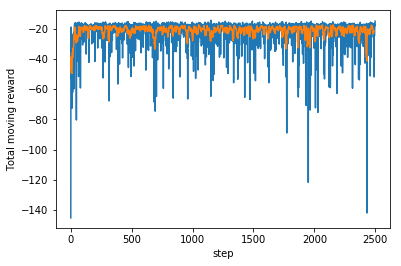

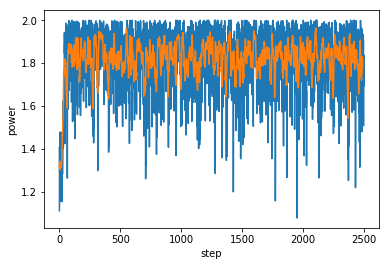

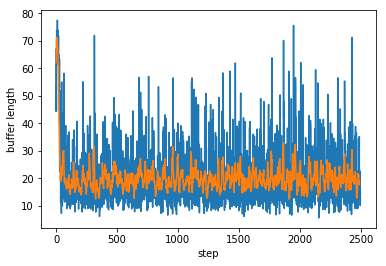

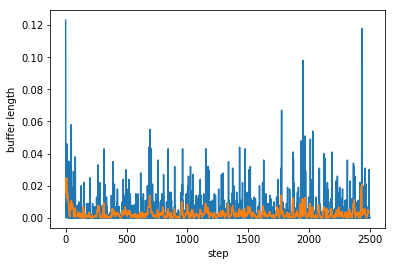

In [3]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

In [1]:
cur_init_ds_ep = env.reset()
    
cur_r_ep = np.zeros(len(user_list))
cur_p_ep = np.zeros(len(user_list))
cur_n_ep = np.zeros(len(user_list))
cur_ts_ep = np.zeros(len(user_list))
cur_rs_ep = np.zeros(len(user_list))
cur_ps_ep = np.zeros(len(user_list))
cur_ds_ep = np.zeros(len(user_list))
cur_ch_ep = np.zeros(len(user_list))
    
for j in range(1000):
    # first try to transmit from current state
    [cur_r, done, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
    cur_r_ep += cur_r
    cur_p_ep += cur_p
    cur_ts_ep += cur_ts
    cur_ps_ep += cur_ps
    cur_rs_ep += cur_rs
    cur_ds_ep += cur_ds
    cur_ch_ep += cur_ch
        
    print('%d:r:%f,p:%s,n:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (j, cur_r, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_init_ds_ep))
        
print('r:%f,p:%s,n:%s,tr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_n_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep))

NameError: name 'env' is not defined

In [3]:
graph = tf.get_default_graph()
inputs = graph.get_tensor_by_name("input_1"+":0")
scaled_out = graph.get_tensor_by_name("output_1"+":0")
print sess.run(scaled_out, feed_dict={inputs: [[7.22254768,2.3384,2.7784888e-05]]})

[[0.78826445 1.        ]]


In [2]:
res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit(False)
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])

0:r:-50.8910,p:1.4033,tr:1.4707,pr:1.3505,rev:2.9594,dbuf:72.5261,ch:0.00002568,ibuf:4
1:r:-57.9454,p:1.3913,tr:1.6529,pr:1.2218,rev:3.0360,dbuf:74.1439,ch:0.00002761,ibuf:30
2:r:-51.0844,p:1.1953,tr:1.5476,pr:1.2320,rev:2.8984,dbuf:73.1955,ch:0.00002990,ibuf:39
3:r:-18.2811,p:1.3469,tr:1.5860,pr:1.3673,rev:2.9762,dbuf:61.5868,ch:0.00002683,ibuf:35
4:r:-17.5547,p:1.2180,tr:1.7657,pr:1.2518,rev:3.0115,dbuf:55.9275,ch:0.00003238,ibuf:63
5:r:-55.6239,p:1.4116,tr:1.4240,pr:1.3390,rev:2.8791,dbuf:69.1011,ch:0.00002492,ibuf:48
6:r:-37.3900,p:1.2706,tr:1.3830,pr:1.5578,rev:3.0240,dbuf:59.5109,ch:0.00002915,ibuf:8
7:r:-32.6223,p:1.4738,tr:1.3452,pr:1.6902,rev:3.0674,dbuf:63.5657,ch:0.00002512,ibuf:71
8:r:-20.8140,p:1.2057,tr:1.4394,pr:1.5456,rev:3.0451,dbuf:49.6221,ch:0.00002902,ibuf:38
9:r:-19.3836,p:1.1973,tr:1.4459,pr:1.4838,rev:2.9358,dbuf:56.0717,ch:0.00002922,ibuf:86


In [3]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import ipdb as pdb
import time

MAX_EPISODE = 50
MAX_EPISODE_LEN = 1000

NUM_T = 1
NUM_R = 1
SIGMA2 = 0.3e-9

config = {'state_dim':3, 'action_dim':2};
train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                 'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                 'random_seed':1234}
user_config = [{'id':'1', 'rate':3, 'dis':100, 'action_bound':1, 
                'data_buf_size':100, 't_factor':0.9, 'penalty':1000}];

print user_config
# 0. initialize the session object
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
    
# 1. include all user in the system according to the user_config
user_list = [];
for info in user_config:
    info.update(config)
    user_list.append(MecTermLD(sess, info, train_config))
    print 'test'

# 2. create the simulation env
env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)
env.init_target_network()

res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])
sess.close()

[{'data_buf_size': 100, 'penalty': 1000, 'rate': 3, 'action_bound': 1, 'id': '1', 't_factor': 0.9, 'dis': 100}]
INFO:tensorflow:Restoring parameters from model/my_test_model
--Return--
None
> <ipython-input-3-a12846566f97>(30)<module>()
     29 graph = tf.get_default_graph()
---> 30 pdb.set_trace()
     31 

ipdb> graph
ipdb> graph.trainable_variables
*** AttributeError: 'Graph' object has no attribute 'trainable_variables'
ipdb> tf.trainable_variables()
[<tf.Variable 'fully_connected/weights:0' shape=(3, 400) dtype=float32_ref>, <tf.Variable 'fully_connected/BatchNorm/beta:0' shape=(400,) dtype=float32_ref>, <tf.Variable 'fully_connected_1/weights:0' shape=(3, 300) dtype=float32_ref>, <tf.Variable 'fully_connected_1/BatchNorm/beta:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'fully_connected_2/weights:0' shape=(300, 2) dtype=float32_ref>, <tf.Variable 'fully_connected_2/biases:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'fully_connected_3/weights:0' shape=(3, 400) dtype=float32

BdbQuit: 

In [9]:
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
variable_names = [v.name for v in tf.trainable_variables()]
values = sess.run(variable_names)
print sess.run('fully_connected_2/weights:0')

INFO:tensorflow:Restoring parameters from model/my_test_model
[[0.1545126  0.15780352]
 [0.15616506 0.15971294]
 [0.06559879 0.09880391]
 [0.06487427 0.10064688]
 [0.15168335 0.16229852]
 [0.06257845 0.09748891]
 [0.06430701 0.09924787]
 [0.06548443 0.10012874]
 [0.15782878 0.15414344]
 [0.15429462 0.17596859]
 [0.05945097 0.0991616 ]
 [0.06383383 0.09632684]
 [0.06522399 0.10438306]
 [0.06095436 0.09916781]
 [0.06635379 0.0955418 ]
 [0.06379106 0.09433711]
 [0.06133086 0.09875894]
 [0.06503102 0.09639146]
 [0.15047684 0.17412661]
 [0.15663381 0.15740666]
 [0.17768952 0.15899988]
 [0.15730077 0.14491995]
 [0.05902164 0.10017106]
 [0.06845198 0.09686822]
 [0.15724926 0.14774598]
 [0.1529071  0.16426612]
 [0.1520101  0.15706535]
 [0.16091335 0.16260217]
 [0.15082897 0.16070077]
 [0.06310375 0.09398151]
 [0.06018374 0.10056869]
 [0.05968894 0.10066012]
 [0.15474424 0.16255529]
 [0.15111688 0.1622602 ]
 [0.0838669  0.18973866]
 [0.06870251 0.24295035]
 [0.06702217 0.10505467]
 [0.1529     

In [3]:
np.save('t_08/1', [1])